## Environment Set-Up

In [2]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git
!pip install scikit-learn
!pip install openpyxl

^C


## Load preprocessed data

In [4]:
import pandas as pd
from sklearn import preprocessing
import joblib

# Load data
data = pd.read_excel("..\TrainData.xlsx")

# Inspection
print("Vorm van de data:", data.shape)

# Split in features and labels
X = data.drop(columns="label")
y = data["label"]

# Scale features
def scale_features(X):
    """Scales features using StandardScaler."""
    scaler = preprocessing.StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

X_scaled = scale_features(X)

# Select features
mask = joblib.load("mask_selected_features.pkl")

X_selected = X_scaled[:,mask]

# Inspection
print("X:", X_selected.shape)


Vorm van de data: (139, 494)
X: (139, 19)


## Randomized Search

In [56]:
import numpy as np
from pprint import pprint

# Define the hyperparameter ranges for RandomForestClassifier

# 1. Number of trees in the forest
n_estimators = [5] + [int(x) for x in np.linspace(start=10, stop=100, num=10)]

# 2. Number of features to consider at every split
max_features = np.linspace(0.1, 1.0, num=10)
max_features = np.round(max_features, 1).tolist()   # Round each number to one decimal place

# 3. Maximum number of levels in a tree
max_depth = [2, 3, 4, 5, 7, 9]    

# 4. Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5, 7, 9, 11, 13, 15]

# 5. Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5, 7, 9]

# Create the random grid of hyperparameters
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

# Print the random grid for inspection
pprint(random_grid)



{'max_depth': [2, 3, 4, 5, 7, 9],
 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
 'min_samples_leaf': [1, 2, 3, 4, 5, 7, 9],
 'min_samples_split': [2, 3, 4, 5, 7, 9, 11, 13, 15],
 'n_estimators': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import joblib

# Create the base RandomForestRegressor model to tune
rf = RandomForestClassifier(bootstrap=True, criterion='gini')

# Use the random grid (defined previously) to search for the best hyperparameters.
# We perform a random search over 5000 different combinations, using 5-fold cross-validation.
# Verbose=2 displays progress details, random_state ensures reproducibility,
# and n_jobs=-1 utilizes all available CPU cores.
rf_random = RandomizedSearchCV(
    estimator=rf,                # The base model
    param_distributions=random_grid,  # The grid of hyperparameters to sample from
    n_iter=10,                  # Number of parameter settings that are sampled
    cv=3,                        # 3-fold cross-validation
    verbose=2,                   # Verbosity level for logging progress
    random_state=42,             # For reproducibility ------> moet dit erbij???
    n_jobs=-1,                    # Use all available cores for parallel processing
    scoring='roc_auc'            # ROC AUC as scoring method
)

# Fit the random search model on the training data
rf_random.fit(X_selected, y)


# save the results of the RandomizedSearchCV
joblib.dump(rf_random, "rf_random_search.pkl")


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


KeyboardInterrupt: 

In [28]:
# Print the best hyperparameters found during the search
print("Best Hyperparameters found: ", rf_random.best_params_)

# Print the best score achieved during the random search
print("Best score: ", rf_random.best_score_)

# Optionally, print the top 10 results based on the mean test score
random_results_df = pd.DataFrame(rf_random.cv_results_)
top_results = random_results_df[['param_n_estimators','param_max_features','param_max_depth','param_min_samples_split','param_min_samples_leaf', 'mean_test_score']]

print("\nTop 20 results:")
print(top_results.sort_values(by='mean_test_score', ascending=False).head(20))

print("\nWorst 20 results:")
print(top_results.sort_values(by='mean_test_score', ascending=False).tail(20))

Best Hyperparameters found:  {'n_estimators': 60, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 0.2, 'max_depth': 15}
Best score:  0.8900047258979206

Top 20 results:
      param_n_estimators  param_max_features  param_max_depth  \
2606                  60                 0.2               15   
4691                  30                 0.2                2   
2020                  70                 0.1                3   
2463                  80                 0.1               15   
3155                  60                 0.1                2   
2603                  30                 0.4                7   
4724                  60                 0.1                9   
3282                  40                 0.1               15   
3612                  60                 0.3               11   
251                   80                 0.1                7   
1798                  60                 0.1                4   
1336                  80            

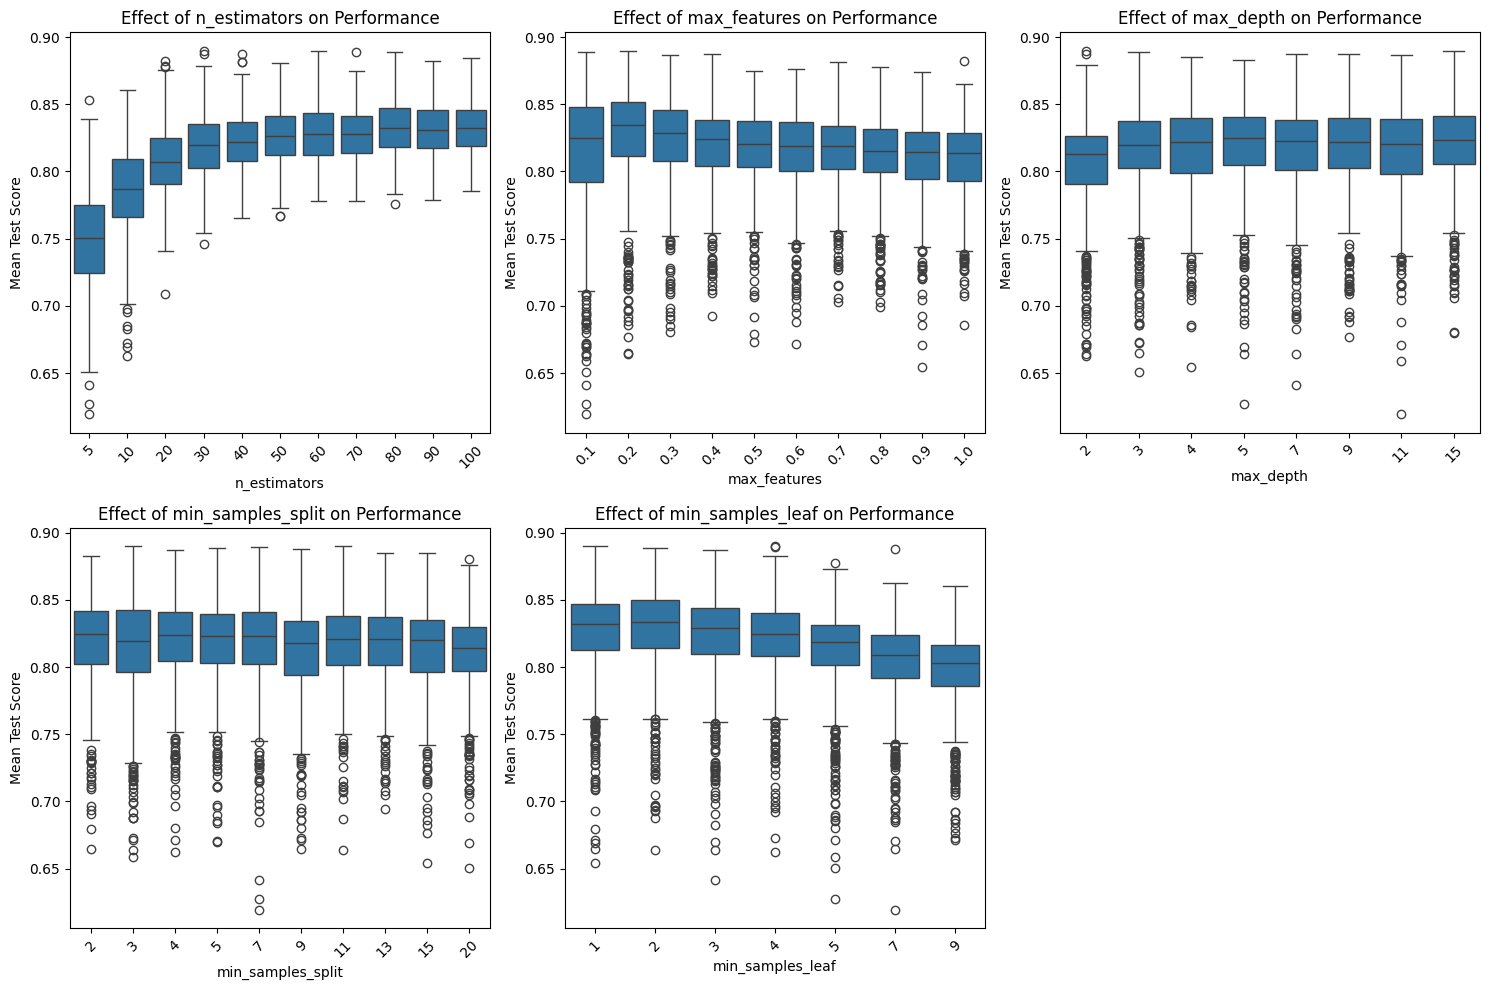

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert results to DataFrame
random_search_results = pd.DataFrame(rf_random.cv_results_)
random_search_results = random_search_results.sort_values(by="mean_test_score", ascending=False)

# List of hyperparameters to visualize
params = ["param_n_estimators", "param_max_features", "param_max_depth", "param_min_samples_split", "param_min_samples_leaf"]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

# Plot each hyperparameter against mean test score
for i, param in enumerate(params):
    sns.boxplot(x=random_search_results[param], y=random_search_results["mean_test_score"], ax=axes[i])
    axes[i].set_xlabel(param.replace("param_", ""))
    axes[i].set_ylabel("Mean Test Score")
    axes[i].set_title(f"Effect of {param.replace('param_', '')} on Performance")
    axes[i].tick_params(axis='x', rotation=45)

# Hide empty subplot if params < 6
if len(params) < len(axes):
    axes[-1].axis('off')

# Save the plot as an image file
plt.savefig('randomized_search_results2.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


## Nested Cross Validation

In [33]:
# Model selection
# Importeren van de benodigde libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Instellen van de hyperparameter grid voor GridSearchCV
param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start=50, stop=70, num=5)],  # Aantal bomen
    'max_features': [0.1, 0.2, 0.3, 0.4, 0.5], 
    'max_depth': [3, 4, 5],  # Diepte van de bomen
    'min_samples_split': [7, 11, 15],  # Minimale samples om een interne split te maken
    'min_samples_leaf': [3, 5, 7],  # Minimale samples in een bladknoop
}

# Print the random grid for inspection
pprint(param_grid)


{'max_depth': [3, 4, 5],
 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5],
 'min_samples_leaf': [3, 5, 7],
 'min_samples_split': [7, 11, 15],
 'n_estimators': [50, 55, 60, 65, 70]}


In [34]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score

# Define outer CV (generalization estimate)
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

# Store results in a list of dictionaries
results = []

# Loop over outer CV folds
for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X_selected, y), 1):
    # Split data
    X_train, X_test = X_selected[train_idx], X_selected[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Inner Grid Search on training set
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
    model = RandomForestClassifier(random_state=42)
    clf = GridSearchCV(model, param_grid, cv=inner_cv, scoring='roc_auc')
    clf.fit(X_train, y_train)

    # Best model from inner loop
    best_model = clf.best_estimator_

    # Evaluate on outer fold test set
    y_pred = best_model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    # Store result
    results.append({
        'fold': fold_idx,
        'roc_auc': roc_auc,
        'best_params': clf.best_params_
    })

    print(f"Outer Fold ROC AUC: {roc_auc:.4f} | Best Params: {clf.best_params_}")

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Final average accuracy
print("\nNested CV Average ROC AUC:", results_df["roc_auc"].mean())

# Save to CSV (optional)
results_df.to_csv("nested_cv_results.csv", index=False)



Outer Fold ROC AUC: 0.6576 | Best Params: {'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 60}
Outer Fold ROC AUC: 0.8261 | Best Params: {'max_depth': 4, 'max_features': 0.2, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 65}
Outer Fold ROC AUC: 0.6957 | Best Params: {'max_depth': 5, 'max_features': 0.1, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 65}

Nested CV Average ROC AUC: 0.7264492753623188


In [35]:
# 1. Get the row with the highest ROC AUC
best_result = results_df.loc[results_df['roc_auc'].idxmax()]

# 2. Extract the best hyperparameters
best_params = best_result['best_params']

# 3. Refit the best model on the full dataset
final_model = RandomForestClassifier(random_state=42, **best_params)
final_model.fit(X_selected, y)

print("✅ Final model trained with best parameters from nested CV:")
print(best_params)

✅ Final model trained with best parameters from nested CV:
{'max_depth': 4, 'max_features': 0.2, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 65}


## Test on tesdata

In [42]:
import pandas as pd
import joblib

# Load data
data_test = pd.read_excel("..\TestData.xlsx")

# Inspection
print("Vorm van de data:", data_test.shape)

# Split in features and labels
X_test = data_test.drop(columns="label")
y_test = data_test["label"]

# Scale features
X_test_scaled = scale_features(X_test)

# Select features
mask = joblib.load("mask_selected_features.pkl")

X_test_selected = X_test_scaled[:,mask]

# Inspection
print("X:", X_test_selected.shape)
print("X:", y_test)


Vorm van de data: (47, 494)
X: (47, 19)
X: 0     1
1     1
2     0
3     0
4     1
5     0
6     1
7     0
8     0
9     1
10    0
11    0
12    0
13    1
14    1
15    1
16    1
17    1
18    0
19    0
20    1
21    0
22    0
23    1
24    0
25    0
26    1
27    0
28    0
29    0
30    0
31    1
32    0
33    1
34    1
35    1
36    1
37    1
38    1
39    0
40    1
41    1
42    1
43    0
44    1
45    0
46    0
Name: label, dtype: int64


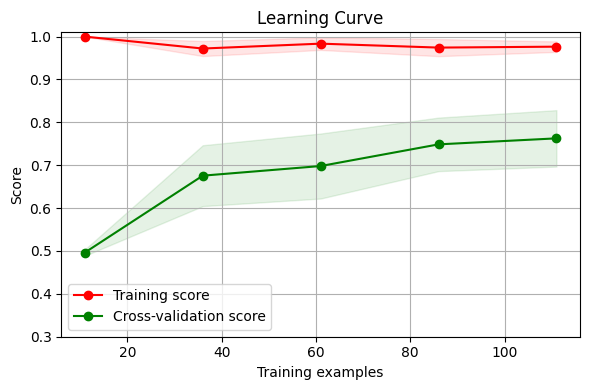

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt
    
# Maak een lege figuur en gebruik huidige as
plt.figure(figsize=(6, 4))
ax = plt.gca()  # Get current axes

# Plot de learning curve
plot_learning_curve(final_model, "Learning Curve", X_selected, y, ax, ylim=(0.3, 1.01), cv=5)

plt.tight_layout()
plt.savefig("learning_curve_rf.png", dpi=300, bbox_inches="tight")
plt.show()



Evaluation on TestData:
Accuracy: 0.745
ROC-AUC: 0.842
F1-Score: 0.750


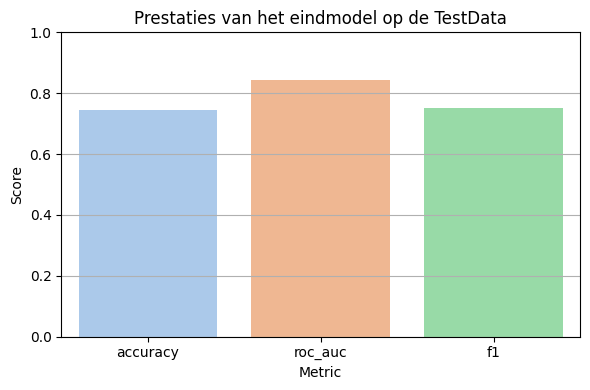

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

final_model.fit(X_selected, y)

# Evaluate best model on TestData
y_pred = final_model.predict(X_test_selected)
y_pred_proba = final_model.predict_proba(X_test_selected)

print("\nEvaluation on TestData:")
print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred):.3f}")
print(f"ROC-AUC: {metrics.roc_auc_score(y_test, y_pred_proba[:, 1]):.3f}")
print(f"F1-Score: {metrics.f1_score(y_test, y_pred):.3f}")

# 🔍 Barplot voor prestaties op TestData
test_scores = {
    "accuracy": metrics.accuracy_score(y_test, y_pred),
    "roc_auc": metrics.roc_auc_score(y_test, y_pred_proba[:, 1]),
    "f1": metrics.f1_score(y_test, y_pred)
}

# Maak een DataFrame van de test_scores dictionary
df_scores = pd.DataFrame(list(test_scores.items()), columns=["Metric", "Score"])

plt.figure(figsize=(6, 4))
sns.barplot(x="Metric", y="Score", data=df_scores, hue="Metric", dodge=False, palette="pastel")
plt.legend([], [], frameon=False)  # Zet de legende uit
plt.ylim(0, 1)
plt.title("Prestaties van het eindmodel op de TestData")
plt.ylabel("Score")
plt.grid(True, axis="y")
plt.tight_layout()

# Save the plot as an image file
plt.savefig('test_scores.png', dpi=300, bbox_inches='tight')

plt.show()


C:\Users\Tessa\AppData\Local\Temp\ipykernel_32176\3090776799.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances_df, palette='viridis')


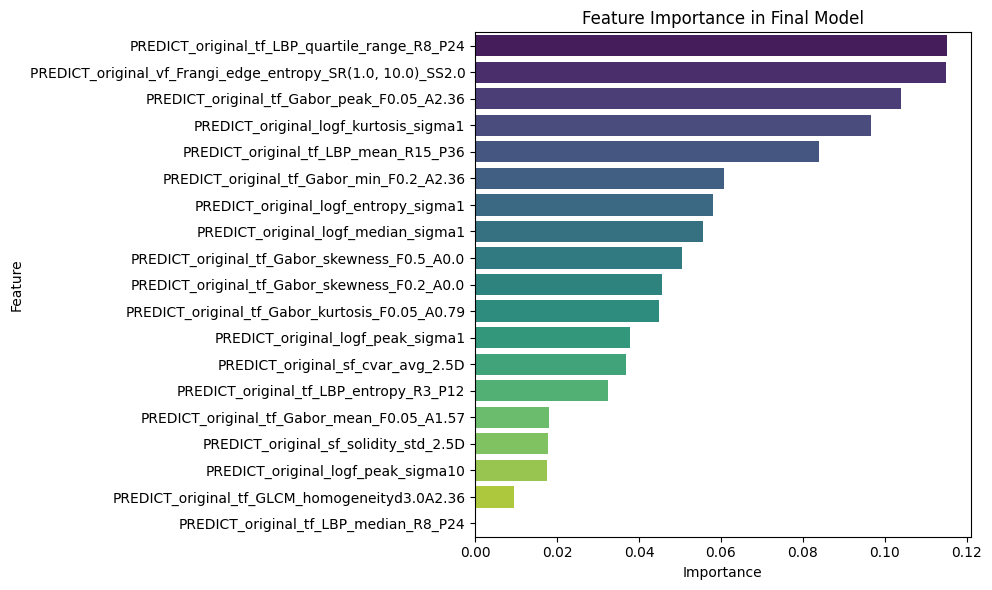

In [107]:
# Get feature importances from the final model
importances = final_model.feature_importances_

# Create a DataFrame with feature names and their importance values
feature_names = X_selected.columns  # assuming X_selected is your feature matrix
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the features by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df, palette='viridis')
plt.title('Feature Importance in Final Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()

# Show the plot
plt.show()


In [80]:
# Get feature importances from the final model
importances = final_model.feature_importances_

# Create a DataFrame with feature names and their importance values
feature_names = X_selected.columns  # assuming X_selected is your feature matrix
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the features by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print("Feature Importances:")
print(feature_importances_df)

Feature Importances:
                                              Feature  Importance
3               PREDICT_original_logf_kurtosis_sigma1    0.111224
10               PREDICT_original_tf_LBP_mean_R15_P36    0.088318
18  PREDICT_original_vf_Frangi_edge_entropy_SR(1.0...    0.085703
16           PREDICT_original_tf_Gabor_min_F0.2_A2.36    0.073421
7              PREDICT_original_tf_LBP_entropy_R3_P12    0.072334
17       PREDICT_original_tf_Gabor_skewness_F0.5_A0.0    0.068458
5                PREDICT_original_logf_entropy_sigma1    0.067226
2                 PREDICT_original_logf_median_sigma1    0.060190
14         PREDICT_original_tf_Gabor_peak_F0.05_A2.36    0.059604
0                   PREDICT_original_sf_cvar_avg_2.5D    0.053828
4                   PREDICT_original_logf_peak_sigma1    0.045448
9       PREDICT_original_tf_LBP_quartile_range_R8_P24    0.040347
11      PREDICT_original_tf_GLCM_homogeneityd3.0A2.36    0.038879
13         PREDICT_original_tf_Gabor_mean_F0.05_A1.57  

In [81]:
# List of feature importances
importances = [0.111224, 0.088318, 0.085703, 0.073421, 0.072334, 0.068458, 0.067226, 
               0.060190, 0.059604, 0.053828, 0.045448, 0.040347, 0.038879, 0.034328, 
               0.029623, 0.028252, 0.023924, 0.016421, 0.002471]

# Check if they sum to 1
sum_of_importances = sum(importances)
print(f"Sum of feature importances: {sum_of_importances:.4f}")

Sum of feature importances: 1.0000
